## Example - Pump Control Model

This example illustrates SWMM 5's Rule-based Control feature
for simulating real-time control. The data file applies to a
combined sewer system with a diversion pump installed to help
prevent local overflows. The scenario modelled contains only
dry weather flow, and illustrates the use of DWF time-of-day
patterns to have DWF vary diurnally. We suggest trying the
following:

1. After opening the file, note how the pump station is modelled
   with a storage node and a Type4 pump. Bring up the Controls
   Editor to view the rules that control the on/off status of the
   pump.

2. Also view the hourly DWF time patterns that are assigned to
   each node that receives DWF. The base-line DWF was set to 1.0
   for these nodes, so the pattern multipliers are the actual flows
   in this example.

3. Run the model for a 24-hour simulation.

4. Create a time series plot of water depth at the storage node and
   flow in the pump on the same graph. See if the plot reflects the
   desired control rules.

5. Create a scatter plot of pump flow versus water depth in the
   storage node and note how this plot is faithful to the control
   rules and to the pump's operating curve.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swmm_api
print(f'{swmm_api.__version__ = }')

swmm_api.__version__ = '0.4.59'


In [3]:
import matplotlib.pyplot as plt
from swmm_api import SwmmInput, SwmmOutput, SwmmReport
from swmm_api.input_file.macros.plotting_map import init_empty_map_plot, add_node_map, add_link_map, add_node_labels, add_link_labels, add_labels
from swmm_api.output_file import OBJECTS, VARIABLES
from swmm_api.run_swmm import swmm5_run_progress
from swmm_api.run_swmm.run_temporary import swmm5_run_temporary

In [5]:
inp = SwmmInput('Pump_Control_Model.inp')

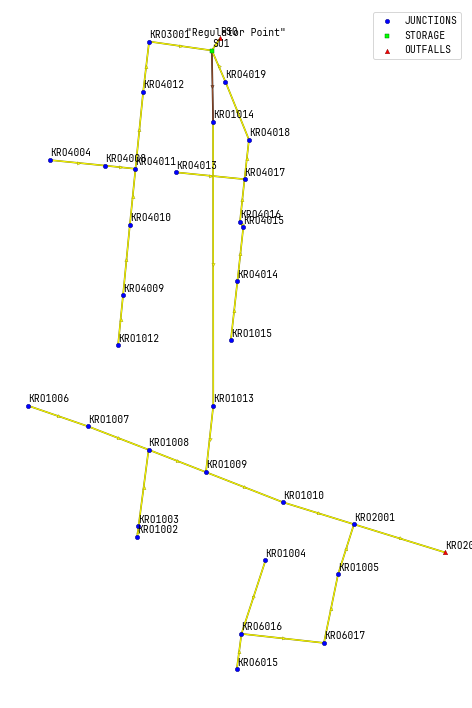

In [6]:
fig, ax = init_empty_map_plot()
add_link_map(ax, inp, add_arrows=True)
add_node_map(ax, inp)
add_node_labels(ax, inp, ha='left', y_offset=15, in_layout=False)
add_labels(ax, inp)
fig.set_dpi(70)
fig.set_size_inches(10, 10)

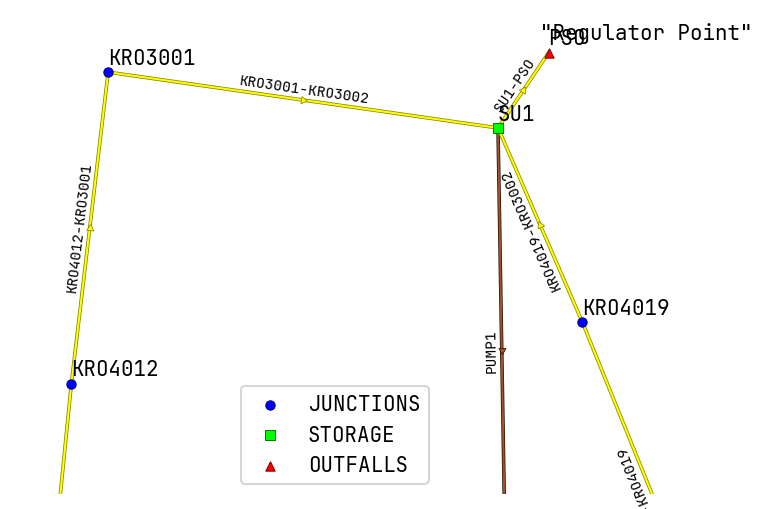

In [7]:
fig, ax = init_empty_map_plot()
add_link_map(ax, inp, add_arrows=True)
add_node_map(ax, inp)
add_node_labels(ax, inp, ha='left', y_offset=5, in_layout=False)
add_link_labels(ax, inp, in_layout=False, size=7, y_offset=4)
add_labels(ax, inp)
ax.set_ylim(430_850, 431_150)
ax.set_xlim(1_362_350, 1_362_750)
fig.set_size_inches(5, 5)
fig.set_dpi(150)
# ax.set_axis_on()
# ax.set_aspect('auto')
# from matplotlib._layoutgrid import plot_children
# plot_children(fig)

In [8]:
inp.PUMPS['PUMP1']

Pump(name='PUMP1', from_node='SU1', to_node='KRO1014', curve_name='PUMP_CURVE1', status='ON', depth_on=0.0, depth_off=0.0)

In [9]:
inp.CURVES['PUMP_CURVE1']

Curve(name='PUMP_CURVE1', kind='PUMP4', points=[[0, 0], [1, 0.2], [2, 0.4], [3, 0.6], [4, 0.9], [17, 0.9]])

In [10]:
inp.STORAGE['SU1']

Storage(name='SU1', elevation=544.74, depth_max=17.0, depth_init=0.0, kind='CYLINDRICAL', data=[6, 6, 0], depth_surcharge=0.0, frac_evaporation=0.0, suction_head=nan, hydraulic_conductivity=nan, moisture_deficit_init=nan)

In [11]:
print(inp.CONTROLS.to_inp_lines())

RULE PUMP1A
IF NODE SU1 DEPTH >= 4
THEN PUMP PUMP1 STATUS = ON
PRIORITY 1

RULE PUMP1B
IF NODE SU1 DEPTH < 1
THEN PUMP PUMP1 STATUS = OFF
PRIORITY 1




### 2.
Also view the hourly DWF time patterns that are assigned to
   each node that receives DWF. The base-line DWF was set to 1.0
   for these nodes, so the pattern multipliers are the actual flows
   in this example.

In [12]:
dwf = inp.PATTERNS['DWF']
dwf

Pattern(name='DWF', cycle='HOURLY', factors=[0.0151, 0.01373, 0.01812, 0.01098, 0.01098, 0.01922, 0.02773, 0.03789, 0.03515, 0.03982, 0.02059, 0.02471, 0.03021, 0.03789, 0.0335, 0.03158, 0.03954, 0.02114, 0.02801, 0.0368, 0.02911, 0.02334, 0.02499, 0.02718])

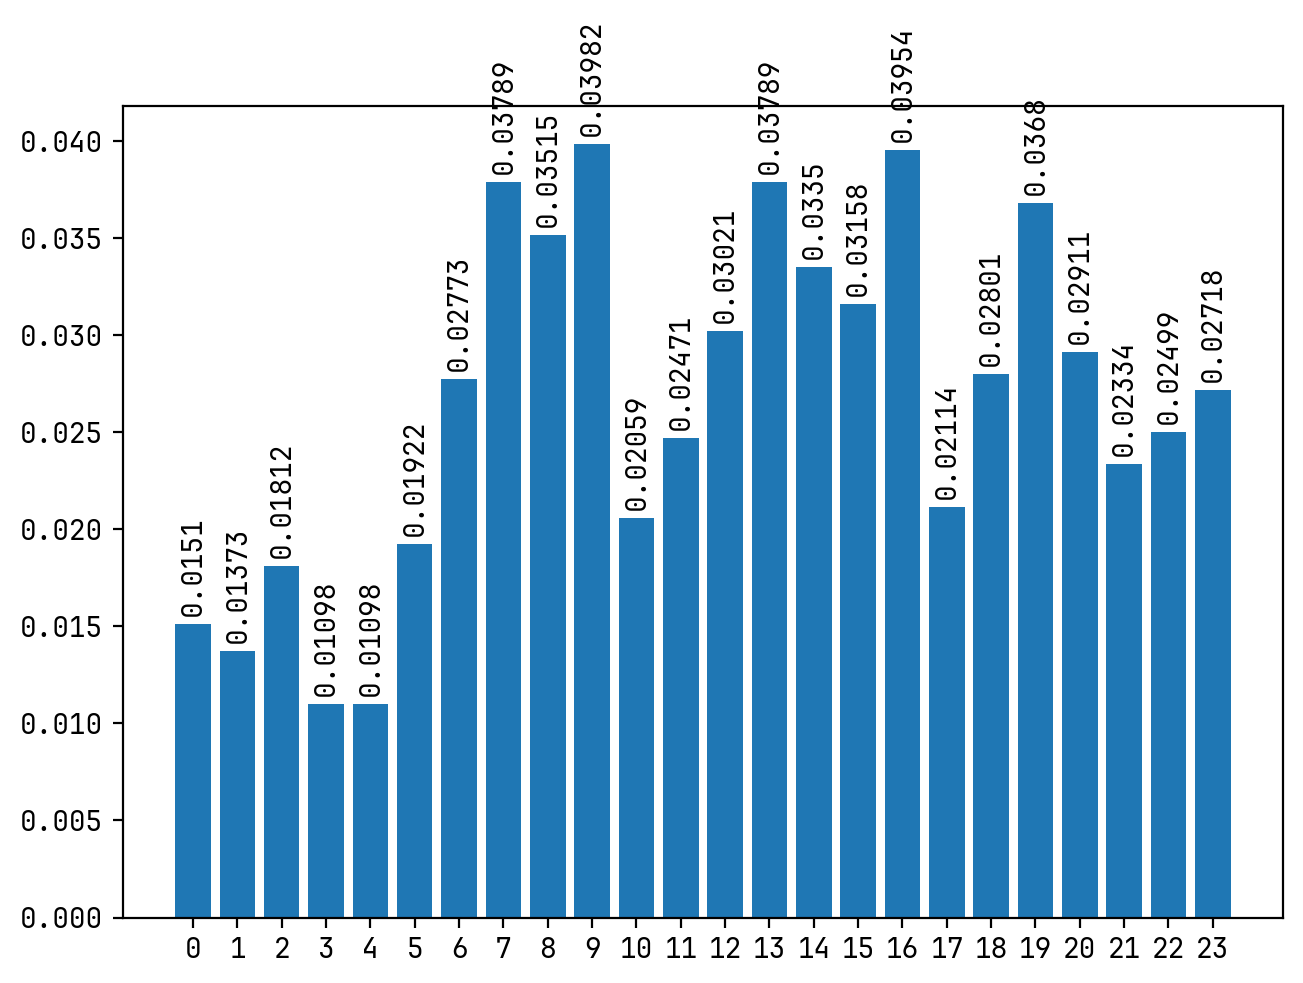

In [13]:
fig, ax = plt.subplots()
x = list(range(len(dwf.factors)))
rects = ax.bar(x, dwf.factors)
ax.set_xticks(x)
_ = ax.bar_label(rects, padding=3, rotation=90)

### 3. 
Run the model for a 24-hour simulation.

In [14]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_progress, label='example_run_swmm') as res:
    out = res.out  # type: SwmmOutput
    rpt = res.rpt  # type: SwmmReport

swmm5 /var/folders/3v/lct6k8mn02xdl7r3zg30bjl00000gn/T/tmpy_1_f2_7/example_run_swmm.inp:   0%|          | 0/10…

### 4.
Create a time series plot of water depth at the storage node and
   flow in the pump on the same graph. See if the plot reflects the
   desired control rules.

Text(0.5, 1.0, 'Flow in the pump')

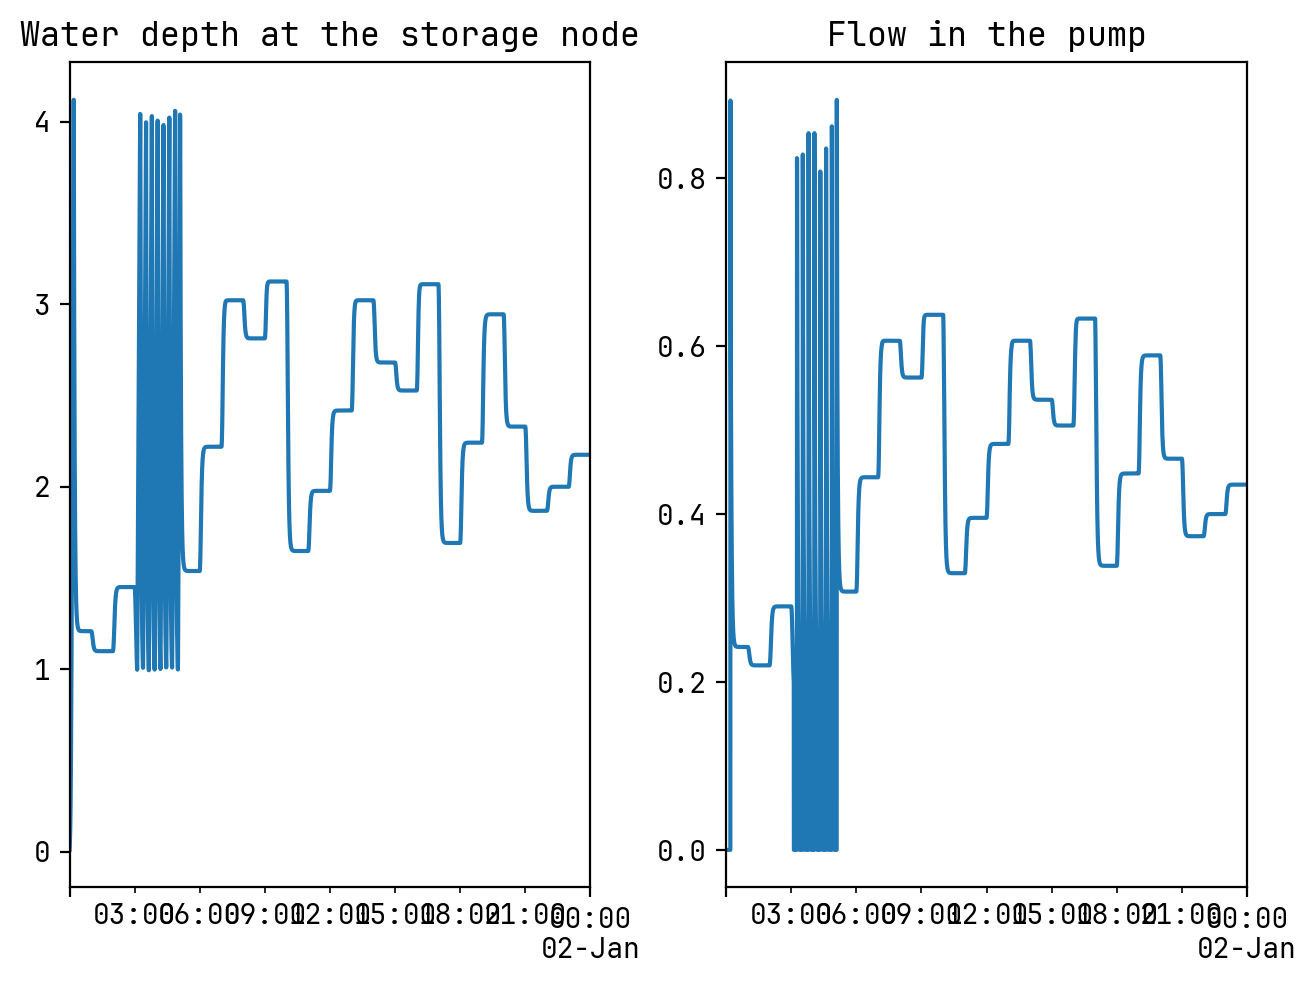

In [15]:
fig, (ax_l, ax_r) = plt.subplots(ncols=2)

out.get_part(OBJECTS.NODE, 'SU1', VARIABLES.NODE.DEPTH).plot(ax=ax_l)
ax_l.set_title('Water depth at the storage node')
out.get_part(OBJECTS.LINK, 'PUMP1', VARIABLES.LINK.FLOW).plot(ax=ax_r)
ax_r.set_title('Flow in the pump')

### 5. 

Create a scatter plot of pump flow versus water depth in the
   storage node and note how this plot is faithful to the control
   rules and to the pump's operating curve.

Text(0.5, 0, 'Flow in the pump')

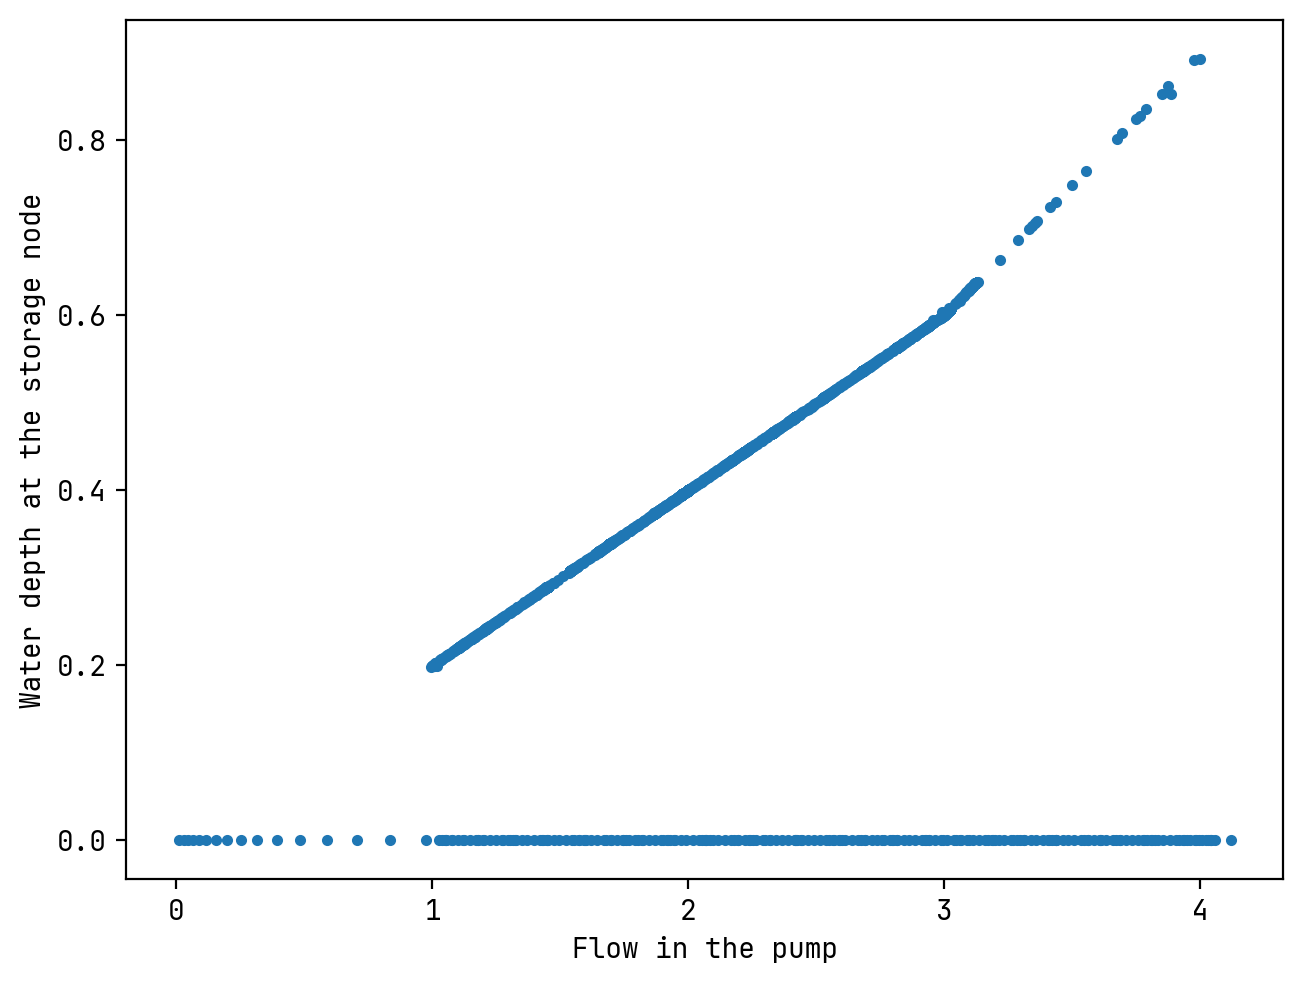

In [16]:
fig, ax = plt.subplots()

ax.plot(out.get_part(OBJECTS.NODE, 'SU1', VARIABLES.NODE.DEPTH), out.get_part(OBJECTS.LINK, 'PUMP1', VARIABLES.LINK.FLOW), lw=0, marker='.')
ax.set_ylabel('Water depth at the storage node')
ax.set_xlabel('Flow in the pump')